## general idea

- woff to text
    - woff file/url to xml file
    - xml file to text (dict)
- text to image
- image to char

## woff to text 

- see Woff2Text.py
- text has been saved in json file

In [108]:
import json

In [109]:
text = json.load(open('./files/demo.json', 'r'))

In [110]:
text['unie055']

{'width': 2584,
 'height': 2282,
 'data': [[[358, 2019],
   [2286, 2019],
   [2286, 1863],
   [1496, 1863],
   [1496, 559],
   [1496, 265],
   [1188, 263],
   [1046, 263],
   [804, 267],
   [794, 345],
   [770, 461],
   [948, 445],
   [1134, 443],
   [1318, 435],
   [1318, 623],
   [1318, 1863],
   [358, 1863]]]}

## text to image, char (see main_chunk.py)

In [111]:
import cv2
import numpy as np
from PIL import Image
import pytesseract

In [112]:
def create_img(item, img_method):
    key = item[0]
    content = item[1]
    im = np.zeros([content['height'], content['width']], dtype=np.uint8)
    if img_method == 'm1':
        for sub_data in content['data']:
            fill_contour(im, sub_data, 255)
    else:
        # ensure line_width >= 1
        line_width = max(int(content['width'] * 0.02), 1)
        for sub_data in content['data']:
            line_contour(im, sub_data, 255, line_width)
        if img_method == 'm2':
            reconstruct_contour(im, 255)
    im = cv2.flip(im, 0)  # flip in x-axis
    im = cv2.resize(im, (256, 256))
    return key, im

In [113]:
def fill_contour(im, sub_data, fill_color):
    new_data = np.array(sub_data, dtype=np.int32).reshape(1, -1, 2)  # reshape is important
    cv2.fillPoly(im, new_data, fill_color)

In [114]:
def line_contour(im, sub_data, fill_color, line_width):
    new_data = np.array(sub_data, dtype=np.int32).reshape(1, -1, 2)
    cv2.polylines(im, new_data, isClosed=1,color=fill_color, thickness=line_width)

In [115]:
# find and fill (only adapt to simple character!!!)
def reconstruct_contour(im, fill_color):
    contours, hierarchy = cv2.findContours(
        im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy.reshape(-1, 4)
    h_level = [[i, dict()] for i in range(len(contours))]
    h_level = dict(h_level)
    sys_level = 0  # it starts from 0 always at idx = 0
    for i in range(len(contours)):
        if not 'level' in h_level[i]:
            tmp = []
            h_level[i]['level'] = sys_level
            tmp.append(i)
            j = i
            while True:
                j = hierarchy[j, 0]
                if j == -1:
                    break
                h_level[j]['level'] = sys_level
                tmp.append(j)
            for k in tmp:
                k = hierarchy[k, 2]
                if k != -1:
                    h_level[k]['level'] = sys_level
            sys_level += 1
        if h_level[i]['level'] % 2 == 0:
            cv2.drawContours(im, contours, i, fill_color, cv2.FILLED)
        else:
            # re-fill dark, very import
            cv2.drawContours(im, contours, i, 0, cv2.FILLED)

In [116]:
def ocr(im):
    # --oem: 0 means original tesseract only
    # --psm: 10 means treat the image as a single character
    # -l: chi_sim means use simplified chinese as parsing fontlib
    config = ('--oem 0 --psm 10 -l chi_sim')
    char = pytesseract.image_to_string(im, config=config)
    return char

In [117]:
def gene_item_path(key, img_method):
    item = (key, text[key])
    img_path = './images/' + key + '_' + img_method + '.png'
    return item, img_path

In [118]:
def text_ocr_pipeline(item, img_method, img_path, true_label):
    key, im = create_img(item, img_method)
    cv2.imwrite(img_path, im)
    char = ocr(im)
    return char, true_label, char==true_label

### use method 1 (fill contour) for defualt imaging

In [119]:
key = 'unie055'
true_label = '丁'

In [120]:
item, img_path = gene_item_path(key, 'm1')

In [121]:
text_ocr_pipeline(item, 'm1', img_path, true_label)

('丁', '丁', True)

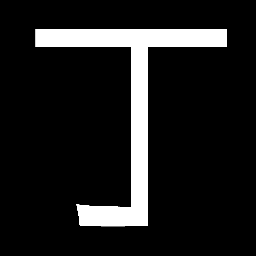

In [122]:
Image.open(img_path)

### use method 2 (reconstruct contour) if method 1 fails

In [123]:
key = 'unie60f'
true_label = '面'

#### method 1 failed to parsing (dense lines in character)

In [124]:
item, img_path = gene_item_path(key, 'm1')

In [125]:
text_ocr_pipeline(item, 'm1', img_path, true_label)

('', '面', False)

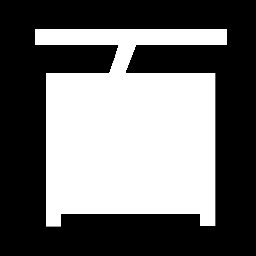

In [126]:
Image.open(img_path)

#### method 2 could treat similar case (but not always work!!! need more thinking)

In [127]:
item, img_path = gene_item_path(key, 'm2')

In [128]:
text_ocr_pipeline(item, 'm2', img_path, true_label)

('面', '面', True)

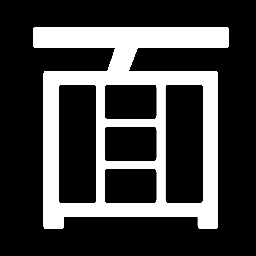

In [129]:
Image.open(img_path)

### use method 3 (line contour) if method 2 still fails

In [130]:
key = 'unie3e1'
true_label = '四'

#### method 1 fails

In [131]:
item, img_path = gene_item_path(key, 'm1')

In [132]:
text_ocr_pipeline(item, 'm1', img_path, true_label)

('.', '四', False)

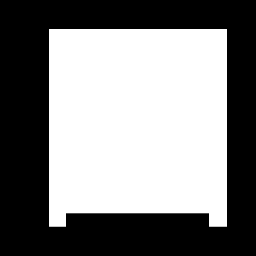

In [133]:
Image.open(img_path)

#### method 2 fails

In [134]:
item, img_path = gene_item_path(key, 'm2')

In [135]:
text_ocr_pipeline(item, 'm2', img_path, true_label)

('', '四', False)

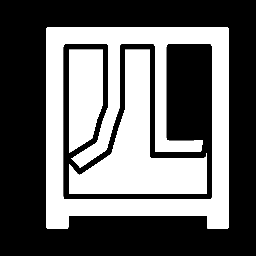

In [136]:
Image.open(img_path)

#### method 3 works

In [137]:
item, img_path = gene_item_path(key, 'm3')

In [138]:
text_ocr_pipeline(item, 'm3', img_path, true_label)

('四', '四', True)

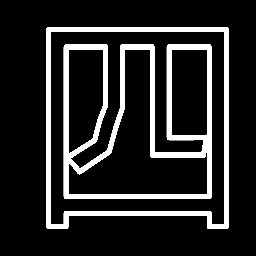

In [139]:
Image.open(img_path)